# 당뇨병 데이터 분류 - 파이토치

In [32]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np

In [33]:
# 데이터 로딩
file_path = "D:/AI_data/diabetes.csv"
df = pd.read_csv(file_path)

df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [34]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [35]:
# 결측치 확인
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [36]:
# 레이블 확인
df['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

In [37]:
# 데이터 분할, 넘파이로 변환
X = df.drop('Outcome', axis=1).values
y = df['Outcome'].values

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [39]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, 

((614, 8), (154, 8), (614,), (154,))

In [40]:
# numpy 배열을 pytorch tensor로 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1) # BCEWithLogitsLoss 사용할 경우 출력 shape을 [batch_size, 1]로 맞춰줘야 하며, 정답 레이블도 float32여야 함
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [41]:
# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True) # 데이터를 작은 묶음(batch)로 나누어 모델에 전달

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [42]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([614, 8]),
 torch.Size([154, 8]),
 torch.Size([614, 1]),
 torch.Size([154, 1]))

## 모델 정의

In [43]:
class DiabetesModel(nn.Module):
    def __init__(self):
        super(DiabetesModel, self).__init__()
        self.fc1 = nn.Linear(8, 64) # fc: fully Connected (완전연결층)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
model = DiabetesModel()

## 손실 함수 및 최적화 기법 정의

In [44]:
criterion = nn.BCEWithLogitsLoss() # 이진 분류
optimizer = optim.Adam(model.parameters(), lr=0.001)

## 모델 학습

In [45]:
# Variables to store loss and accuracy
train_losses = []
test_accuracies = []

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train() # 학습
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()  # 이전 그래디언트 초기화

        # Forward pass
        outputs = model(inputs) # 모델에 데이터 통과시켜 예측
        loss = criterion(outputs, labels) # 손실 계산

        # Backward pass and optimize
        loss.backward()
        optimizer.step() # 가중치 업데이트

        running_loss += loss.item()

    # 평균 손실 저장
    train_losses.append(running_loss / len(train_dataloader))

    # Evaluate on test data
    model.eval() # 평가
    correct = 0
    total = 0
    with torch.no_grad(): # 그래디언트 계산 생략, 더 빠름
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            predicted = torch.sigmoid(outputs)  # sigmoid: 로짓을 0~1 사이의 확률로 바꿈 (이진 분류일 때)
            predicted = (predicted >= 0.5).float()  # 예측값이 0.5 이상이면 1, 아니면 0
            # _, predicted = torch.max(outputs.data, 1) # 가장 높은 확률을 갖는 클래스를 예측으로 선택 (다중 분류일 때)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total # 정확도 = 정답 / 전체
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")

print("Training complete.")

Epoch 1/20, Loss: 0.6610, Accuracy: 77.27%
Epoch 2/20, Loss: 0.6093, Accuracy: 77.92%
Epoch 3/20, Loss: 0.5591, Accuracy: 79.87%
Epoch 4/20, Loss: 0.5061, Accuracy: 79.22%
Epoch 5/20, Loss: 0.4806, Accuracy: 78.57%
Epoch 6/20, Loss: 0.4798, Accuracy: 79.87%
Epoch 7/20, Loss: 0.4634, Accuracy: 79.22%
Epoch 8/20, Loss: 0.4553, Accuracy: 79.22%
Epoch 9/20, Loss: 0.4642, Accuracy: 81.17%
Epoch 10/20, Loss: 0.4568, Accuracy: 79.87%
Epoch 11/20, Loss: 0.4538, Accuracy: 79.22%
Epoch 12/20, Loss: 0.4501, Accuracy: 78.57%
Epoch 13/20, Loss: 0.4442, Accuracy: 80.52%
Epoch 14/20, Loss: 0.4428, Accuracy: 80.52%
Epoch 15/20, Loss: 0.4592, Accuracy: 79.87%
Epoch 16/20, Loss: 0.4305, Accuracy: 80.52%
Epoch 17/20, Loss: 0.4455, Accuracy: 79.87%
Epoch 18/20, Loss: 0.4254, Accuracy: 78.57%
Epoch 19/20, Loss: 0.4414, Accuracy: 79.87%
Epoch 20/20, Loss: 0.4247, Accuracy: 79.22%
Training complete.


## 모델 평가

In [46]:
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        predicted = torch.sigmoid(outputs)
        predicted = (predicted >= 0.5).float()
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate metrics
conf_matrix = confusion_matrix(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')

# Calculate specificity for each class
specificity = []
for i in range(conf_matrix.shape[0]):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity.append(tn / (tn + fp))

print(f'Confusion Matrix:\n{conf_matrix}')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {np.mean(specificity):.2f}')

Confusion Matrix:
[[93 14]
 [18 29]]
F1 Score: 0.79
Precision: 0.79
Recall: 0.79
Specificity: 0.74


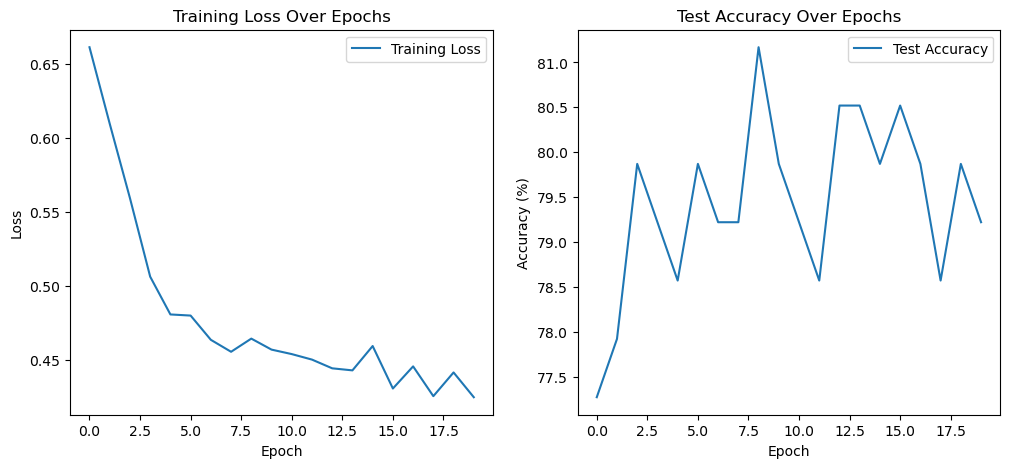

In [47]:
# Plot the loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.show()